In [4]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import re
from wordcloud import WordCloud

### Download Necessary NLTK Data

To perform text preprocessing and sentiment analysis, we need to download the necessary NLTK data.


In [5]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

### Load the Dataset

In this section, we load the dataset containing Amazon gift card reviews. The dataset is in JSON format and includes various fields such as review text, ratings, and reviewer information. This data will be used for further analysis and sentiment evaluation.

In [6]:
# Load the dataset
url = 'https://raw.githubusercontent.com/Timothy965/COMP262_GROUP5/main/Dataset/Gift_Cards_5.json'
df = pd.read_json(url, lines=True)

# Function to check if a column is hashable
def is_hashable(s):
    return all(isinstance(x, (int, float, str, bool)) for x in s.dropna())

### Dateset Exploration
In this section, we explore the dataset to understand its structure and key characteristics. The following steps are performed:

1. **Basic Information**:
    - Total number of reviews
    - Average rating
    - Average review length
    - Dataframe info: Displays the structure and data types of the dataframe.

2. **Distribution of Reviews Across Products**:
    - We analyze the distribution of the number of reviews across different products using a histogram.

3. **Distribution of Reviews per User**:
    - We examine how many reviews each user has written and visualize this distribution.

4. **Review Lengths and Outliers**:
    - We analyze the lengths of the reviews and identify any outliers using a boxplot.

5. **Duplicate Reviews**:
    - We check for duplicate reviews using hashable columns and find that there are no duplicate reviews in the dataset.

Total number of reviews: 2972
Average rating: 4.885262449528937
Average review length: 67.46729602157788
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2972 entries, 0 to 2971
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         2972 non-null   int64  
 1   verified        2972 non-null   bool   
 2   reviewTime      2972 non-null   object 
 3   reviewerID      2972 non-null   object 
 4   asin            2972 non-null   object 
 5   style           864 non-null    object 
 6   reviewerName    2972 non-null   object 
 7   reviewText      2966 non-null   object 
 8   summary         2972 non-null   object 
 9   unixReviewTime  2972 non-null   int64  
 10  vote            208 non-null    float64
 11  image           12 non-null     object 
dtypes: bool(1), float64(1), int64(2), object(8)
memory usage: 258.4+ KB
Dataframe info
 None


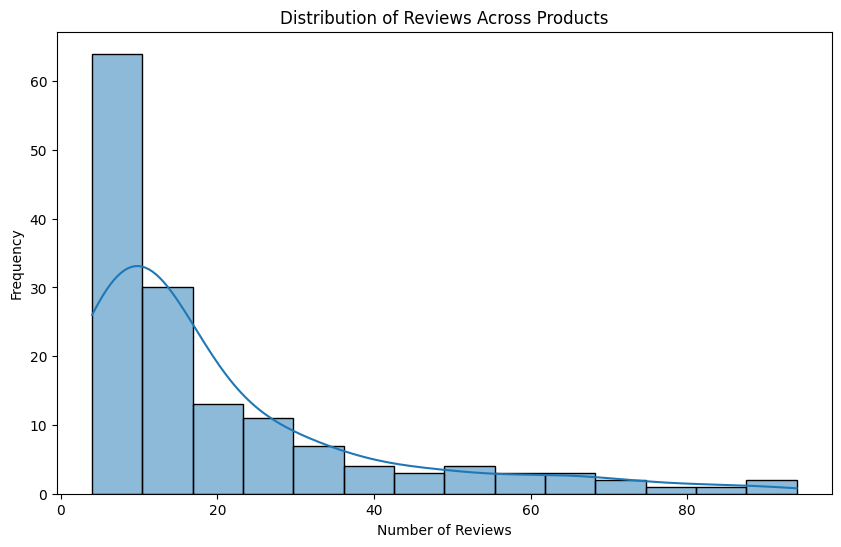

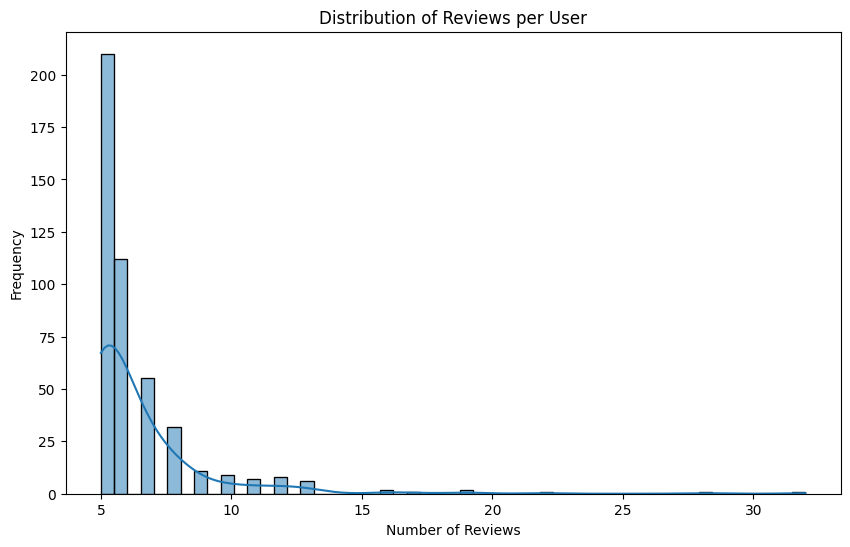

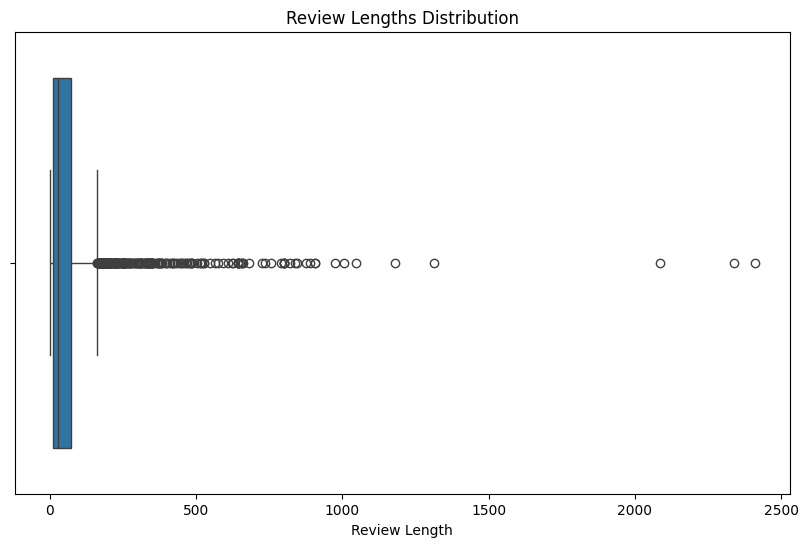

Minimum review length: 2.0
Maximum review length: 2409.0
Median review length: 29.0
Columns used for duplicate checking: ['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote']
Number of duplicate reviews (using hashable columns): 0


In [7]:
# 1. Dataset data exploration
# a) Counts, averages, infor
print("Total number of reviews:", len(df))
print("Average rating:", df['overall'].mean())
print("Average review length:", df['reviewText'].str.len().mean())
print("Dataframe info\n", df.info())

# b) Distribution of the number of reviews across products
product_review_counts = df['asin'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(product_review_counts, kde=True)
plt.title('Distribution of Reviews Across Products')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

# d) Distribution of reviews per user
user_review_counts = df['reviewerID'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(user_review_counts, kde=True)
plt.title('Distribution of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

# e) Review lengths and outliers
review_lengths = df['reviewText'].str.len()
plt.figure(figsize=(10, 6))
sns.boxplot(x=review_lengths)
plt.title('Review Lengths Distribution')
plt.xlabel('Review Length')
plt.show()

# f) Analyze lengths
print("Minimum review length:", review_lengths.min())
print("Maximum review length:", review_lengths.max())
print("Median review length:", review_lengths.median())

# g) Check for duplicates
# We'll check for duplicates using only hashable columns
hashable_columns = [col for col in df.columns if is_hashable(df[col])]
print("Columns used for duplicate checking:", hashable_columns)
duplicate_count = df.duplicated(subset=hashable_columns).sum()
print("Number of duplicate reviews (using hashable columns):", duplicate_count)

20 Most Frequent Words:
gift: 1679
card: 854
great: 720
love: 350
cards: 349
amazon: 292
good: 282
christmas: 188
like: 167
perfect: 159
worked: 158
nice: 155
use: 154
loved: 150
get: 134
always: 125
give: 122
easy: 110
time: 109
food: 109


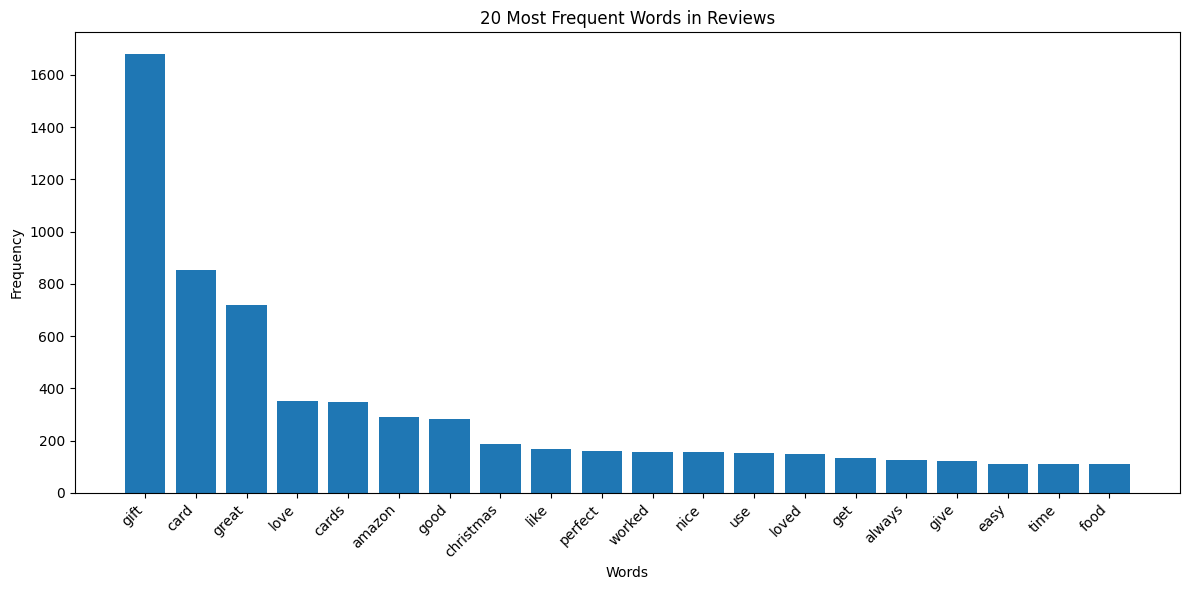

In [8]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and non-alphabetic tokens
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# Combine all review texts
all_text = ' '.join(df['reviewText'].dropna())

# Preprocess the combined text
words = preprocess_text(all_text)

# Count word frequencies
word_freq = Counter(words)

# Get the 20 most common words
most_common_words = word_freq.most_common(20)

# Print the results
print("20 Most Frequent Words:")
for word, count in most_common_words:
    print(f"{word}: {count}")

# Visualize the results
words, counts = zip(*most_common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.title('20 Most Frequent Words in Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

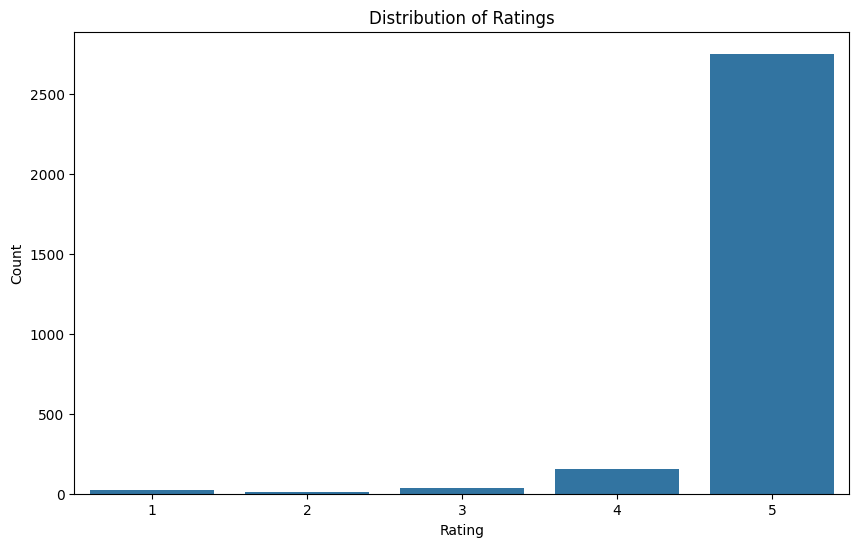

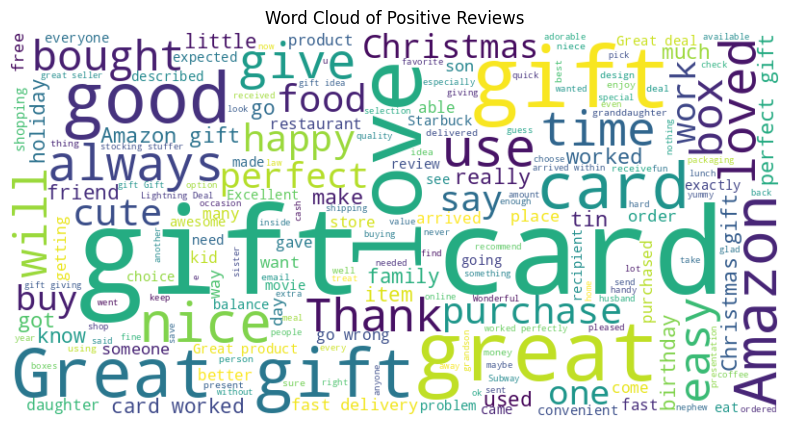

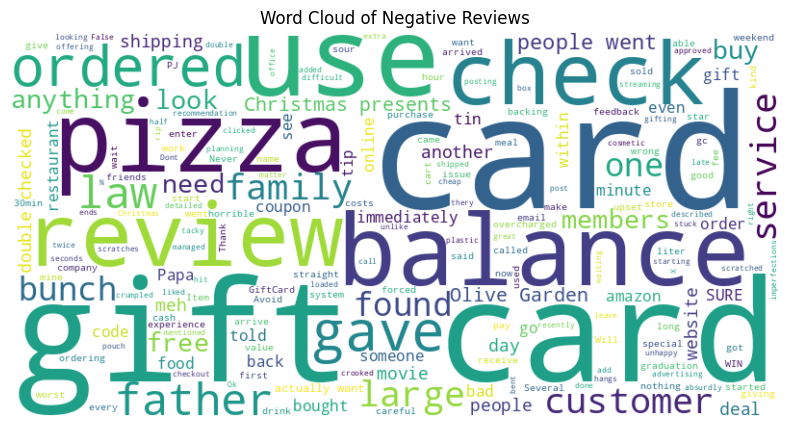

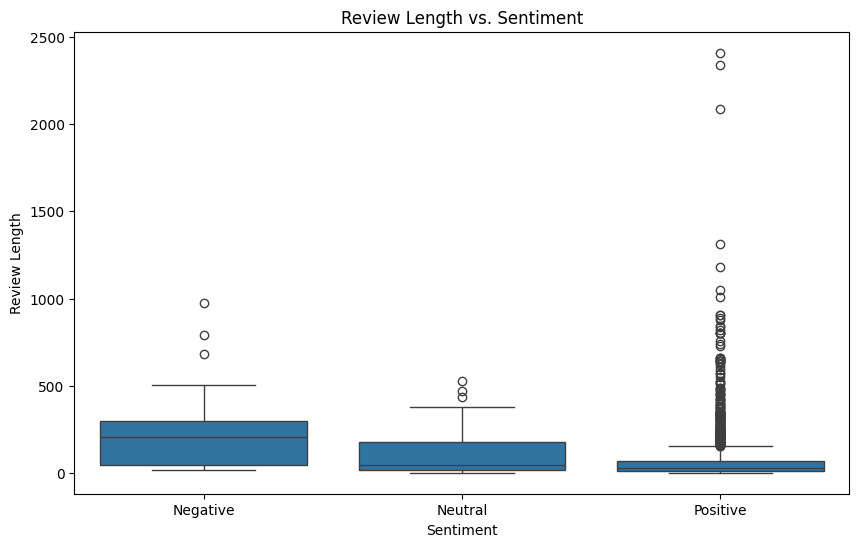


Average review length by sentiment:
sentiment
Negative    238.575758
Neutral     122.121212
Positive     64.898276
Name: review_length, dtype: float64


Correlation between review length and rating: -0.15


In [9]:
#  Rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='overall', data=df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()
print()

#  Word clouds for positive and negative reviews
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Positive reviews (rating >= 4)
positive_reviews = ' '.join(df[df['overall'] >= 4]['reviewText'].dropna())
generate_wordcloud(positive_reviews, 'Word Cloud of Positive Reviews')
print()

# Negative reviews (rating <= 2)
negative_reviews = ' '.join(df[df['overall'] <= 2]['reviewText'].dropna())
generate_wordcloud(negative_reviews, 'Word Cloud of Negative Reviews')
print()

# Review length analysis
df['review_length'] = df['reviewText'].str.len()

# Create sentiment categories
df['sentiment'] = pd.cut(df['overall'],
                         bins=[-np.inf, 2, 3, np.inf],
                         labels=['Negative', 'Neutral', 'Positive'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='review_length', data=df)
plt.title('Review Length vs. Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.show()

# Calculate average review length for each sentiment
avg_length = df.groupby('sentiment')['review_length'].mean()
print("\nAverage review length by sentiment:")
print(avg_length)
print()

# Correlation between review length and rating
correlation = df['review_length'].corr(df['overall'])
print(f"\nCorrelation between review length and rating: {correlation:.2f}")


### Text Basic Pre-processing

In this section, we perform basic text pre-processing to prepare the review texts for sentiment analysis. The steps involved are:

1. **Label Data Based on Rating**:
    - Reviews are labeled as 'Positive', 'Neutral', or 'Negative' based on their rating.

2. **Select Appropriate Columns for Sentiment Analysis**:
    - We choose the columns `reviewText`, `summary`, and `sentiment` for sentiment analysis.

3. **Check for Outliers in Review Length**:
    - We calculate the Interquartile Range (IQR) and use it to identify outliers in the review lengths.

In [10]:
# 2. Text basic pre-processing

# a) Label data based on rating
def label_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = df['overall'].apply(label_sentiment)

# b) Choose appropriate columns for sentiment analysis
selected_columns = ['reviewText', 'summary', 'sentiment']
sentiment_df = df[selected_columns]

# c) Check for outliers in review length
Q1 = review_lengths.quantile(0.25)
Q3 = review_lengths.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [11]:
outliers = review_lengths[(review_lengths < lower_bound) | (review_lengths > upper_bound)]
print(f"Number of outliers in review length: {len(outliers)}")

Number of outliers in review length: 271


In [12]:
# Display first few rows of the sentiment dataframe
print(sentiment_df.head())

                                         reviewText  \
0                               Another great gift.   
1                         Gift card for my daughter   
2                                      Nice present   
3  My niece loved this birthday greeting/gift card.   
4                                   fine as a gift.   

                          summary sentiment  
0                      Five Stars  Positive  
1                     Ease of use  Positive  
2                      Five Stars  Positive  
3  Love the convenience of eCards  Positive  
4                      Five Stars  Positive  


### Distribution of Sentiments

The distribution of sentiments in the dataset is visualized below:

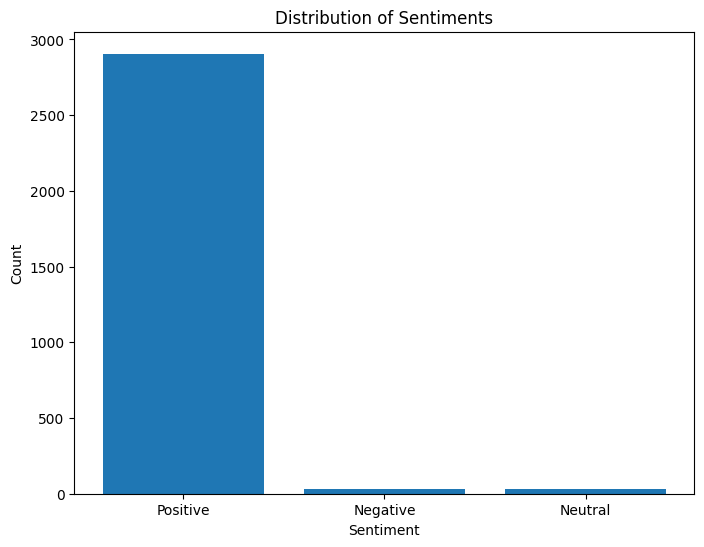

In [13]:
# Distribution of sentiments
sentiment_counts = Counter(sentiment_df['sentiment'])
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.keys(), sentiment_counts.values())
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

### Text Preprocessing

The `preprocess_text` function performs the following steps on the text data:
- Lowercasing
- Removing punctuation
- Tokenization
- Removing stop words
- Lemmatization

In [14]:
# Pre-process the text
def preprocess_vader(text):
    # Convert to lowercase for consistency
    text = text.lower()

    # Keep emojis and exclamation points, but remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove hashtags and mentions, which don't add sentiment value
    text = re.sub(r'@\w+|#', '', text)

    # Reduce elongated words (like "coooool") to handle emphasis without over-weighting
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove special characters and replace with space
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    return text


stop_words = set(stopwords.words('english'))

# Define a custom list of stopwords to retain for sentiment
sentiment_stopwords = {
    'not', 'no', 'nor', 'never', 'neither',   # Negations
    'very', 'too', 'so', 'really', 'quite', 'just', 'pretty', 'much', 'even', # Intensifiers
    'barely', 'hardly', 'little', 'merely', 'scarcely', 'almost', # Diminishers
    'but', 'yet', 'though', 'although', 'however', 'despite', # Connectives
    'only', 'alone', 'solely', # Exclusives
    'if', 'unless', 'except', # Conditionals
    'sure', 'always', 'forever', # Positives
    'ever', 'still', 'especially', 'exactly', 'absolutely' # General Emphasis
}

# Remove all stopwords except the sentiment-carrying ones
filtered_stopwords = stop_words - sentiment_stopwords

def preprocess_textblob_with_important_stopwords(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and replace with space
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenize and remove non-sentiment-carrying stopwords
    text = ' '.join(word for word in text.split() if word not in filtered_stopwords)

    return text


In [15]:

sentiment_df_vader = pd.DataFrame(sentiment_df)
sentiment_df_textblob = pd.DataFrame(sentiment_df)

sentiment_df_vader['reviewText'] = sentiment_df_vader['reviewText'].astype(str).apply(preprocess_vader)
sentiment_df_vader['summary'] = sentiment_df_vader['summary'].astype(str).apply(preprocess_vader)

sentiment_df_textblob['reviewText'] = sentiment_df_textblob['reviewText'].astype(str).apply(preprocess_textblob_with_important_stopwords)
sentiment_df_textblob['summary'] = sentiment_df_textblob['summary'].astype(str).apply(preprocess_textblob_with_important_stopwords)


In [16]:
print(sentiment_df_vader.head())
print(sentiment_df_textblob.head())

                                         reviewText  \
0                               another great gift    
1                         gift card for my daughter   
2                                      nice present   
3  my niece loved this birthday greeting gift card    
4                                   fine as a gift    

                          summary sentiment  
0                      five stars  Positive  
1                     ease of use  Positive  
2                      five stars  Positive  
3  love the convenience of ecards  Positive  
4                      five stars  Positive  
                                reviewText                  summary sentiment
0                       another great gift               five stars  Positive
1                       gift card daughter                 ease use  Positive
2                             nice present               five stars  Positive
3  niece loved birthday greeting gift card  love convenience ecards  Positive
4  

### Selecting 1000 Reviews from the Dataset

To perform further analysis, we will randomly select 1000 reviews from the dataset.

In [17]:
# Randomly select 1000 reviews from the dataset
sampled_reviews = sentiment_df.sample(n=1000, random_state=42)
print(sampled_reviews)

                                             reviewText  \
2400                     Amazon gift cards are AMAZING!   
2862                                         Great deal   
2167                Great product from a great seller!!   
507                     great gift and the tin is cool.   
2839  Very cute tag and on the back you can add a sm...   
...                                                 ...   
2171                       Very nice gift presentation.   
1251                                       nice product   
821   Gave to family members (and myself) as they lo...   
343                                            loved it   
2726                        Gift cards are always good.   

                                                summary sentiment  
2400                                         Five Stars  Positive  
2862                                         Five Stars  Positive  
2167                                         Five Stars  Positive  
507                

### Sentiment Analysis Using VADER and TextBlob

In this section, we will perform sentiment analysis on the preprocessed review texts using two different sentiment analysis tools: VADER and TextBlob.

1. **VADER Sentiment Analysis**:
    - VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.
    - We will use the `SentimentIntensityAnalyzer` from the `nltk.sentiment.vader` module to analyze the sentiment of the review texts.
    - The `vader_sentiment` function calculates the compound sentiment score for each review text.

2. **TextBlob Sentiment Analysis**:
    - TextBlob is a simple library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks.
    - We will use the `TextBlob` library to calculate the polarity of each review text.
    - The `textblob_sentiment` function calculates the polarity score for each review text.

The results of both sentiment analysis tools will be added as new columns to the `sentiment_df` dataframe. We will then display the first few rows of the dataframe with the new sentiment scores.

In [18]:
# Initialize the sentiment analyzers
vader_analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment using VADER
def vader_sentiment(text):
    score = vader_analyzer.polarity_scores(text)
    return score['compound']

# Apply VADER sentiment analysis
sentiment_df['reviewText'] = sentiment_df['reviewText'].fillna('')  # Handle missing values
sentiment_df['vader_sentiment'] = sentiment_df['reviewText'].apply(vader_sentiment)

# Function to get sentiment using TextBlob
def textblob_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply TextBlob sentiment analysis
sentiment_df['textblob_sentiment'] = sentiment_df['reviewText'].apply(textblob_sentiment)

# Display the first few rows of the dataframe with the new sentiment scores
print(sentiment_df.head())

                                         reviewText  \
0                               Another great gift.   
1                         Gift card for my daughter   
2                                      Nice present   
3  My niece loved this birthday greeting/gift card.   
4                                   fine as a gift.   

                          summary sentiment  vader_sentiment  \
0                      Five Stars  Positive           0.7906   
1                     Ease of use  Positive           0.4404   
2                      Five Stars  Positive           0.4215   
3  Love the convenience of eCards  Positive           0.5994   
4                      Five Stars  Positive           0.5719   

   textblob_sentiment  
0            0.800000  
1            0.000000  
2            0.300000  
3            0.700000  
4            0.416667  


### Correlation Between VADER and TextBlob Sentiment Scores

In this section, we calculate the correlation between the sentiment scores obtained from VADER and TextBlob. The correlation value helps us understand the relationship between the two sentiment analysis tools.

We also create a comparison table that shows the average sentiment scores for each sentiment category (Positive, Neutral, Negative) as determined by both VADER and TextBlob.

In [19]:
# Calculate the correlation between VADER and TextBlob sentiment scores
correlation = sentiment_df['vader_sentiment'].corr(sentiment_df['textblob_sentiment'])
print(f"Correlation between VADER and TextBlob sentiment scores: {correlation}")

# Create a comparison table
comparison_table = sentiment_df.groupby('sentiment').agg({
    'vader_sentiment': 'mean',
    'textblob_sentiment': 'mean'
}).reset_index()

print(comparison_table)

Correlation between VADER and TextBlob sentiment scores: 0.4600662041566369
  sentiment  vader_sentiment  textblob_sentiment
0  Negative         0.174936           -0.006102
1   Neutral         0.344533            0.134321
2  Positive         0.573263            0.452788


### Sentiment Analysis Evaluation

In this section, we evaluate the performance of VADER and TextBlob sentiment analysis tools by comparing their sentiment labels with the actual sentiment labels in the dataset. We use confusion matrices and classification reports to assess their accuracy.

- **Confusion Matrices**: Visualize the performance of the sentiment analysis tools by comparing the predicted labels with the true labels.
- **Classification Reports**: Provide detailed metrics such as precision, recall, and F1-score for each sentiment category (Positive, Neutral, Negative).


VADER Classification Report:
              precision    recall  f1-score   support

    Positive       0.98      0.87      0.93      2906
     Neutral       0.01      0.09      0.02        33
    Negative       0.18      0.45      0.26        33

    accuracy                           0.86      2972
   macro avg       0.39      0.47      0.40      2972
weighted avg       0.96      0.86      0.91      2972


TextBlob Classification Report:
              precision    recall  f1-score   support

    Positive       0.99      0.76      0.86      2906
     Neutral       0.02      0.30      0.03        33
    Negative       0.11      0.33      0.17        33

    accuracy                           0.76      2972
   macro avg       0.37      0.47      0.35      2972
weighted avg       0.97      0.76      0.85      2972

VADER Confusion Matrix:
[[2542  302   62]
 [  25    3    5]
 [  17    1   15]]

TextBlob Confusion Matrix:
[[2223  600   83]
 [  19   10    4]
 [  10   12   11]]


Text(627.9949494949494, 0.5, 'True Label')

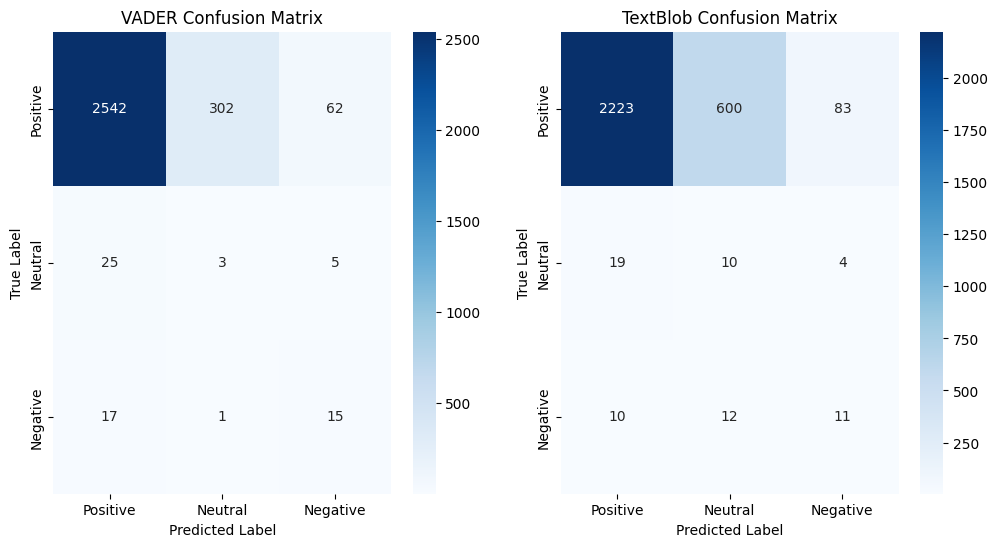

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

# Define a function to convert sentiment scores to labels
def score_to_label(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Convert VADER and TextBlob sentiment scores to labels
sentiment_df['vader_label'] = sentiment_df['vader_sentiment'].apply(score_to_label)
sentiment_df['textblob_label'] = sentiment_df['textblob_sentiment'].apply(score_to_label)

# Create confusion matrices
vader_cm = confusion_matrix(sentiment_df['sentiment'], sentiment_df['vader_label'], labels=['Positive', 'Neutral', 'Negative'])
textblob_cm = confusion_matrix(sentiment_df['sentiment'], sentiment_df['textblob_label'], labels=['Positive', 'Neutral', 'Negative'])

# Print classification reports
print("\nVADER Classification Report:")
print(classification_report(sentiment_df['sentiment'], sentiment_df['vader_label'], labels=['Positive', 'Neutral', 'Negative']))

print("\nTextBlob Classification Report:")
print(classification_report(sentiment_df['sentiment'], sentiment_df['textblob_label'], labels=['Positive', 'Neutral', 'Negative']))

# Print confusion matrices
print("VADER Confusion Matrix:")
print(vader_cm)
print("\nTextBlob Confusion Matrix:")
print(textblob_cm)

# Plot the confusion matrices
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(vader_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.title('VADER Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 2, 2)
sns.heatmap(textblob_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.title('TextBlob Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

## PHASE 2: Modeling and Comparison with Phase 1

In this phase, we will build and evaluate machine learning models for sentiment analysis. We will compare the performance of these models with the results obtained from the VADER and TextBlob sentiment analysis tools in Phase 1. The steps involved are:

1. **Data Preparation**:
    - Prepare the dataset for modeling by splitting it into training and testing sets.
    - Vectorize the text data using techniques such as TF-IDF.

2. **Model Building**:
    - Train various machine learning models (e.g., Logistic Regression, SVM, Naïve Bayes, Gradient Boosting, MLP) on the training data.
    - Evaluate the models using appropriate metrics.

3. **Model Comparison**:
    - Compare the performance of the machine learning models with the VADER and TextBlob sentiment analysis tools.
    - Use metrics such as accuracy, precision, recall, and F1-score for comparison.

4. **Conclusion**:
    - Summarize the findings and discuss the strengths and weaknesses of each approach.


In [21]:
import numpy as np

# Set a seed for reproducibility
np.random.seed(42)

### Load the Phase 2 Dataset

In this section, we load the dataset for Phase 2, which contains Amazon gift card reviews. The dataset is in JSON format and includes various fields such as review text, ratings, and reviewer information.

In [22]:
import pandas as pd

# Load the dataset
url = "https://raw.githubusercontent.com/Timothy965/COMP262_GROUP5/refs/heads/main/Dataset/Gift_Cards_Phase2.json"
data = pd.read_json(url, lines=True)

# Display the first few rows of the dataset
print(data.head())

# Print name of columns
print(data.columns)

   overall vote  verified   reviewTime      reviewerID        asin  \
0        1   25     False  12 19, 2008   APV13CM0919JD  B001GXRQW0   
1        5  NaN     False  12 17, 2008  A3G8U1G1V082SN  B001GXRQW0   
2        5    4     False  12 17, 2008   A11T2Q0EVTUWP  B001GXRQW0   
3        5  NaN     False  12 17, 2008   A9YKGBH3SV22C  B001GXRQW0   
4        1  NaN      True  12 17, 2008  A34WZIHVF3OKOL  B001GXRQW0   

                     style reviewerName  \
0  {'Gift Amount:': ' 50'}          LEH   
1  {'Gift Amount:': ' 50'}         Tali   
2  {'Gift Amount:': ' 50'}            Z   
3  {'Gift Amount:': ' 25'}   Giotravels   
4                      NaN     King Dad   

                                          reviewText  \
0  Amazon,\nI am shopping for Amazon.com gift car...   
1  I got this gift card from a friend, and it was...   
2  aren't we going to save trees?! :) People who ...   
3  You can always get someone something from Amaz...   
4  Why take 50 dollars of good money wit

### Sampled Dataset

We have created a sample of the dataset with 2000 rows for further analysis. Below are the first few rows of the sampled dataset.

In [23]:
# Get samples based on overall rating
positive_samples = data[data['overall'] >= 4].sample(n=667, random_state=42)
neutral_samples = data[data['overall'] == 3].sample(n=666, random_state=42)
negative_samples = data[data['overall'] <= 2].sample(n=667, random_state=42)

# Combine the samples
data_sample = pd.concat([positive_samples, neutral_samples, negative_samples])

# Display the distribution of the overall ratings in the balanced sample
print(data_sample['overall'].value_counts())

overall
3    666
5    616
1    536
2    131
4     51
Name: count, dtype: int64


### Combine Review Text and Summary

In this section, we combine the `reviewText` and `summary` columns to create a new `text` column for further analysis.

In [24]:
# Combine the reviewText and summary columns to create a new text column
data_sample['text'] = data_sample['reviewText'] + ' ' + data_sample['summary']

# Display the first few rows of the dataset with the new text column
print(data_sample.head())

       overall vote  verified   reviewTime      reviewerID        asin style  \
92013        5  NaN      True  01 16, 2014  A3ST3GSGBB4GRL  B00G4IWEZG   NaN   
39658        5  NaN      True   01 6, 2012  A33Y8C4818EJL0  B005ESMMWW   NaN   
16926        5  NaN      True  12 29, 2013  A1ES51HXHVDSSI  B004LLILGO   NaN   
62928        5  NaN      True  07 15, 2016   AU94BGU1186F1  B00ADR2XIC   NaN   
40382        4  NaN      True  01 25, 2015  A29TOGXZD0YK0D  B0062ONJRE   NaN   

               reviewerName  \
92013              sue dail   
39658  Live Laugh Love More   
16926     Beatriz Rodriguez   
62928                AKBW59   
40382          Ben McLennan   

                                              reviewText  \
92013  This was the easiest Christmas gift I gave thi...   
39658  What more can one ask for at Christmastime?  K...   
16926  i bought all i wanted, just in time to take ad...   
62928                    Beautiful box, no need to wrap!   
40382                         Si

In [25]:
# Check for missing values
print(data_sample.isnull().sum())

# Check the distribution of ratings
print(data_sample['overall'].value_counts())

# check for duplicates
duplicates = data_sample.duplicated(subset=['text'])
print("Number of duplicates:", duplicates.sum())


overall              0
vote              1738
verified             0
reviewTime           0
reviewerID           0
asin                 0
style             1421
reviewerName         0
reviewText           0
summary              0
unixReviewTime       0
image             1984
text                 0
dtype: int64
overall
3    666
5    616
1    536
2    131
4     51
Name: count, dtype: int64
Number of duplicates: 29


### Emoji and Emoticon Detection

In this section, we detect emojis and emoticons in the text data. We use the `emoji` library to identify emojis and a predefined list to detect common emoticons. The results are stored in a new column `emojis_emoticons`.

In [26]:
!pip install emoji
# Detect emojis and emoticons in the text

# Import the emoji library
import emoji

# List of common emoticons
emoticons = [':)', ':(', ':D', ':P', ':-)', ':-(', ':-D', ':-P', ';)', ';-)', ':o', ':-o', ':O', ':-O', ':]', ':[', ':-]', ':-[']

# Function to detect emojis and emoticons in a text
def detect_emojis_emoticons(text):
    return [c for c in text if c in emoji.EMOJI_DATA or c in emoticons]

# Detect emojis and emoticons in the text
data_sample['emojis_emoticons'] = (data_sample['text'].astype(str)).apply(detect_emojis_emoticons)

# Display number of rows with emojis or emoticons
print('Rows with emojis or emoticons:', data_sample['emojis_emoticons'].apply(len).gt(0).sum())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 12.6 MB/s eta 0:00:00
Rows with emojis or emoticons: 0


### Language Detection

In this section, we detect the language of the reviews to ensure that only English reviews are included in our analysis. Non-English reviews are identified and displayed.

Some of the texts were being detected as not english because of spelling issues and text not being clean. The text is cleaned to reduce this. Then it uses  textblob spell correction to reduce the false detections even further. As a fall back langid is used to detect language once more if it is not english. This further reduces false detections.

In [27]:
!pip install langdetect
!pip install langid

# Check if there are non-english reviews
from langdetect import detect, DetectorFactory
import langid
from textblob import TextBlob
import re

# Set seed for reproducibility
DetectorFactory.seed = 42

# Function to detect language with conditional spell correction
def detect_language(text):
    try:
        lang = detect(text)
        if lang != 'en':
            # Correct spelling mistakes
            corrected_text = str(TextBlob(text).correct())
            lang = detect(corrected_text)
            if lang != 'en':
                # Fallback to langid
                lang, _ = langid.classify(corrected_text)
    except:
        lang = 'unknown'
    return lang

# Function to clean text
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Convert non-string values to strings
data_sample['text'] = data_sample['text'].astype(str)

# Clean the text before language detection
data_sample['cleaned_text'] = data_sample['text'].apply(clean_text)

# Apply language detection
data_sample['language'] = data_sample['cleaned_text'].apply(detect_language)

# Display the language distribution
print(data_sample['language'].value_counts())

# Print couple of non-english reviews
non_english_reviews = data_sample[data_sample['language'] != 'en']
print(non_english_reviews[['text', 'language', 'cleaned_text']])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=cb99ef2af82746bbb8d700a4dac717aa0ca103222440f1599192e356392819ed
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=62f69b4bdfcf26df52bc8525caf0d0e20b754495dd9d7f8ddcc7cf12763cf243
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid
language
en    1988
es       4
de       3
da       1
ca       1
nb       1
pt       1
it       1
Name: count, dtype: int64
                                                    

## Preprocessing

### Drop non-english reviews

In this section, we detect the language of the reviews to ensure that only English reviews are included in our analysis. Non-English reviews are identified and dropped based on the already detected `language` column.

In [28]:
# Drop non-english reviews
data_sample = data_sample[data_sample['language'] == 'en']

# print the number of reviews after dropping non-english reviews
print("Number of reviews after dropping non-english reviews:", len(data_sample))

Number of reviews after dropping non-english reviews: 1988


### Column Dropping

In this section, we clean the dataset by dropping unnecessary columns. This helps in focusing on the relevant data for our analysis.

In [29]:
# Print all coloumns in the dataset
print(data_sample.columns)

# Drop unnecessary columns
data_sample_copy = data_sample.drop(columns=['vote', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'image', 'emojis_emoticons', 'cleaned_text', 'language'])

# Display the first few rows of the dataset after dropping columns
print(data_sample_copy.head())

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'image', 'text', 'emojis_emoticons', 'cleaned_text', 'language'],
      dtype='object')
       overall                                               text
92013        5  This was the easiest Christmas gift I gave thi...
39658        5  What more can one ask for at Christmastime?  K...
16926        5  i bought all i wanted, just in time to take ad...
62928        5          Beautiful box, no need to wrap! Beautiful
40382        4      Simple and easy to produce Nativity Gift card


### Missing values and Duplicates

In this section, we clean the dataset by handling missing values and removing duplicates. This ensures that our data is accurate and ready for analysis.

In [30]:
# Print the missing values in the dataset
print("Missing values in the dataset:")
print(data_sample_copy.isnull().sum())

# Drop rows with missing values
data_sample_copy = data_sample_copy.dropna()

# check for duplicates
duplicates = data_sample_copy.duplicated(subset=['text'])
print("Number of duplicates:", data_sample_copy.duplicated(subset=['text']).sum())

# Print the duplicated rows
print(data_sample_copy[duplicates])

# Drop duplicates
data_sample_copy = data_sample_copy.drop_duplicates(subset=['text'])

# Display the shape of the dataset after removing duplicates
print(data_sample_copy.shape)

Missing values in the dataset:
overall    0
text       0
dtype: int64
Number of duplicates: 29
        overall                                               text
139357        5                                    Good Five Stars
128653        5                                   Great Five Stars
47656         5                                   Great Five Stars
94028         5                                    Nice Five Stars
3627          5                     It was a great gift Five Stars
120184        5                                   Great Five Stars
124774        5                                  Great. Five Stars
37932         5                                    good Five Stars
13833         5                                   Great Five Stars
33230         5                              Great gift Five Stars
74854         5                           Perfect gift. Five Stars
85433         5                                    good Five Stars
65775         5                   

### Sentiment Labeling

In this section, we label the data based on the rating. Reviews are categorized as 'Positive', 'Neutral', or 'Negative' based on their rating. The labeled data will be used for further analysis and modeling.

In [31]:
# Label the data based on the rating
def label_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

# Apply the label_sentiment function to the overall column
data_sample_copy['sentiment'] = data_sample_copy['overall'].apply(label_sentiment)

# Drop the overall column
data_sample_copy = data_sample_copy.drop(columns=['overall'])

# Display the first few rows of the dataset with the sentiment labels
print(data_sample_copy.head())

                                                    text sentiment
92013  This was the easiest Christmas gift I gave thi...  Positive
39658  What more can one ask for at Christmastime?  K...  Positive
16926  i bought all i wanted, just in time to take ad...  Positive
62928          Beautiful box, no need to wrap! Beautiful  Positive
40382      Simple and easy to produce Nativity Gift card  Positive


### Sentiment Analysis and Review Length

In this section, we analyze the relationship between review length and sentiment. We perform the following steps:

1. **Review Length Analysis**:
    - Calculate the length of each review and create a new column `review_length`.
    - Visualize the distribution of review lengths across different sentiment categories using a boxplot.
    - Calculate the average review length for each sentiment category.

2. **Correlation Analysis**:
    - Calculate the correlation between review length and rating to understand the relationship between these two variables.

3. **Outlier Detection**:
    - Identify outliers in review lengths using the Interquartile Range (IQR) method.
    - Calculate the number of outliers for each sentiment category.

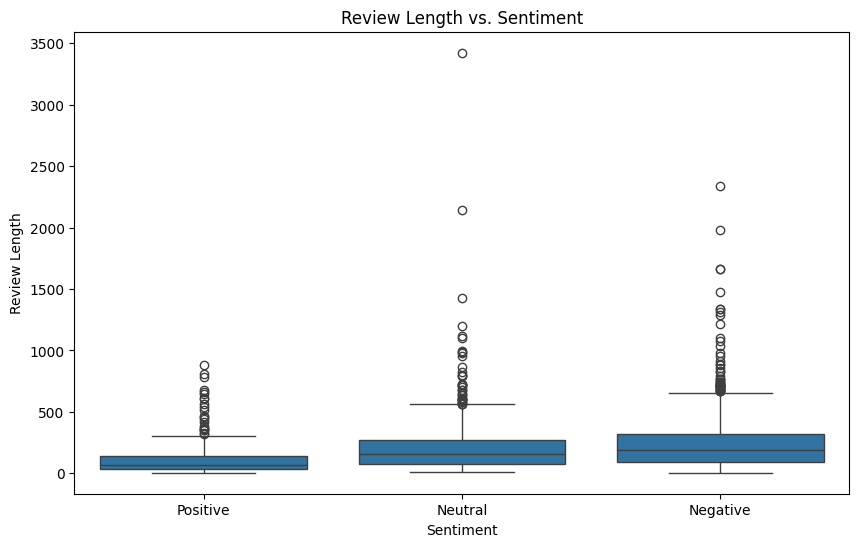


Average review length by sentiment:
sentiment
Negative    257.432881
Neutral     213.050305
Positive    106.439063
Name: review_length, dtype: float64


Correlation between review length and rating: -0.28
Number of outliers in review length: 139

Number of outliers by sentiment:
sentiment
Negative    83
Neutral     46
Positive    10
dtype: int64


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Review length analysis
data_sample_copy['review_length'] = data_sample_copy['text'].str.len()

plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='review_length', data=data_sample_copy)
plt.title('Review Length vs. Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.show()

# Calculate average review length for each sentiment
avg_length = data_sample_copy.groupby('sentiment', observed=False)['review_length'].mean()
print("\nAverage review length by sentiment:")
print(avg_length)
print()

# Correlation between review length and rating
correlation = data_sample_copy['review_length'].corr(data_sample_copy['sentiment'].map({'Positive': 1, 'Neutral': 0, 'Negative': -1}))
print(f"\nCorrelation between review length and rating: {correlation:.2f}")

# Print the number of outliers in review length
Q1 = data_sample_copy['review_length'].quantile(0.25)
Q3 = data_sample_copy['review_length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data_sample_copy['review_length'][(data_sample_copy['review_length'] < lower_bound) | (data_sample_copy['review_length'] > upper_bound)]
print(f"Number of outliers in review length: {len(outliers)}")

# Print the number of outliers for each sentiment label
outliers_by_sentiment = data_sample_copy[data_sample_copy['review_length'].isin(outliers)].groupby('sentiment', observed=False).size()
print("\nNumber of outliers by sentiment:")
print(outliers_by_sentiment)

### Text Preprocessing and Cleaning

In this section, we preprocess and clean the text data to prepare it for further analysis. The steps involved are:

1. **Define Custom Stopwords**:
    - We define a custom list of stopwords to retain for sentiment analysis, including negations, intensifiers, diminishers, connectives, and other sentiment-carrying words.

2. **Preprocess Text Function**:
    - The `preprocess_text` function performs the following steps on the text data:
        - Remove URLs, mentions, and HTML tags.
        - Reduce elongated words.
        - Remove extra whitespace.
        - Remove punctuations and special characters but retain exclamation points.
        - Tokenize and remove non-sentiment-carrying stopwords.

3. **Test Preprocessing**:
    - We test the `preprocess_text` function with a sample string containing URLs, negations, intensifiers, and other elements to ensure it works as expected.

4. **Apply Preprocessing**:
    - We apply the `preprocess_text` function to the `text` column of the dataset and create a new column `cleaned_text` with the preprocessed text.

5. **Display Results**:
    - We display the first few rows of the dataset with the original and cleaned text to verify the preprocessing steps.

In [33]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Define the custom list of stopwords to retain for sentiment
sentiment_stopwords = {
    'not', 'no', 'nor', 'never', 'neither', 'none', 'nobody', 'nothing', 'nowhere', # Negations
    'very', 'too', 'so', 'really', 'quite', 'just', 'pretty', 'much', 'even', 'extremely', 'highly', 'incredibly', 'remarkably', # Intensifiers
    'barely', 'hardly', 'little', 'merely', 'scarcely', 'almost', 'slightly', 'somewhat', 'marginally', # Diminishers
    'but', 'yet', 'though', 'although', 'however', 'despite', 'still', 'nevertheless', 'nonetheless', 'whereas', # Connectives
    'only', 'alone', 'solely', 'merely', 'exclusively', 'purely', # Exclusives
    'if', 'unless', 'except', 'provided', 'assuming', 'lest', # Conditionals
    'sure', 'always', 'forever', 'certainly', 'definitely', 'undoubtedly', 'absolutely', # Positives
    'ever', 'still', 'especially', 'exactly', 'absolutely', 'particularly', 'specifically', 'precisely', 'surely', 'truly', 'undeniably', # General Emphasis
    'shan', 'hasn', 'won', 'isn', 'aren', 'wasn', 'weren', 'don', 'doesn', 'didn', 'haven', 'hadn', 'wouldn', 'shouldn', 'mightn', 'mustn', 'couldn', 'cannot', # Additional Negations
}

# Remove all stopwords except the sentiment-carrying ones
stop_words = set(stopwords.words('english'))
filtered_stopwords = stop_words - sentiment_stopwords

def preprocess_text(text):
    # Remove URLs, mentions, and HTML tags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#', '', text)
    text = re.sub(r'<.*?>', '', text)

    # Reduce elongated words
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove punctuations and special characters but retain exclamation points
    text = re.sub(r'[^a-zA-Z0-9\s!]', '', text)

    # Tokenize and remove non-sentiment-carrying stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in filtered_stopwords]

    return ' '.join(tokens)


# Test string for the preprocess_text function with URLs and negations and intensifiers and so on
test_string = "I'm so happy! I can't believe I won =. It's amazing! https://example.com #happy #winner. Isn't that so amazing!!!!! Wasn't even thinking about winning but I did. Soooooo COOOOOL"
print(f"Test String for testing preprocessing: \n{test_string} \nPreprocessed text: \n{preprocess_text(test_string)}\n")

# Apply the preprocess_text function to the text column
data_sample_copy['cleaned_text'] = data_sample_copy['text'].apply(preprocess_text)

# Display the first few rows of the dataset with the cleaned text
print(data_sample_copy[['sentiment', 'text', 'cleaned_text']].head())

Test String for testing preprocessing: 
I'm so happy! I can't believe I won =. It's amazing! https://example.com #happy #winner. Isn't that so amazing!!!!! Wasn't even thinking about winning but I did. Soooooo COOOOOL 
Preprocessed text: 
Im so happy ! I cant believe I won Its amazing ! happy winner Isnt so amazing ! ! Wasnt even thinking winning but I Soo COOL

      sentiment                                               text  \
92013  Positive  This was the easiest Christmas gift I gave thi...   
39658  Positive  What more can one ask for at Christmastime?  K...   
16926  Positive  i bought all i wanted, just in time to take ad...   
62928  Positive          Beautiful box, no need to wrap! Beautiful   
40382  Positive      Simple and easy to produce Nativity Gift card   

                                            cleaned_text  
92013  This easiest Christmas gift I gave year I knew...  
39658  What one ask Christmastime Keep simple This ea...  
16926  bought wanted just time take a

### Sentiment Distribution Plot

In this section, we visualize the distribution of sentiments in the dataset using a bar plot. This helps us understand the proportion of positive, neutral, and negative reviews.

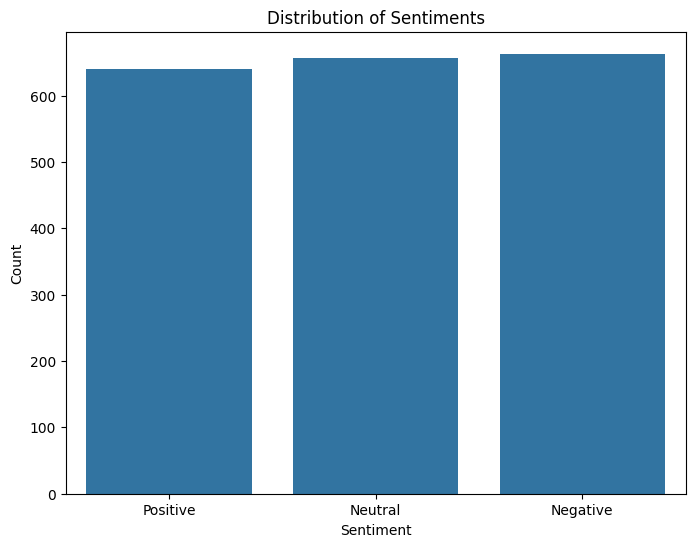

In [34]:
# Plot the distribution of sentiments
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=data_sample_copy)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

### Balancing the Dataset

In this section, we balance the dataset by upsampling the minority classes to match the size of the majority class. This ensures that the model is trained on a balanced dataset, improving its performance and accuracy.

In [35]:
from sklearn.utils import resample

# Separate the majority and minority classes
positive = data_sample_copy[data_sample_copy['sentiment'] == 'Positive']
neutral = data_sample_copy[data_sample_copy['sentiment'] == 'Neutral']
negative = data_sample_copy[data_sample_copy['sentiment'] == 'Negative']

# Find the maximum class size
max_size = max(len(positive), len(neutral), len(negative))

# Upsample the minority classes
positive_upsampled = resample(positive, replace=True, n_samples=max_size, random_state=42)
neutral_upsampled = resample(neutral, replace=True, n_samples=max_size, random_state=42)
negative_upsampled = resample(negative, replace=True, n_samples=max_size, random_state=42)

# Combine the upsampled classes to create a balanced dataset
balanced_data = pd.concat([positive_upsampled, neutral_upsampled, negative_upsampled])

# Display the distribution of the balanced dataset
print(balanced_data['sentiment'].value_counts())

sentiment
Positive    663
Neutral     663
Negative    663
Name: count, dtype: int64


### TF-IDF Vectorization

In this section, we create TF-IDF vectors for the cleaned text data. This helps in converting the text data into numerical features that can be used for machine learning models.

In [36]:
# Create tf-idf vectors for the cleaned text
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Create the tf-idf vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(balanced_data['cleaned_text'])

# Display the shape of the tf-idf matrix
print("Shape of the tf-idf matrix:", tfidf_matrix.shape)

Shape of the tf-idf matrix: (1989, 3580)


### Train-Test Split

In this section, we split the data into training and testing sets using stratified splitting to ensure that the distribution of sentiments is maintained in both sets. We also display the distribution of ratings in the training and testing sets.

In [37]:
from sklearn.model_selection import train_test_split

# Define the features (TF-IDF matrix) and labels (overall rating)
X = tfidf_matrix
y = balanced_data['sentiment']

# Split the data into training and testing sets with stratified splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Display the distribution of ratings in the training and testing sets
print("Training set rating distribution:\n", y_train.value_counts(normalize=True))
print("\nTesting set rating distribution:\n", y_test.value_counts(normalize=True))

Training set rating distribution:
 sentiment
Neutral     0.333333
Negative    0.333333
Positive    0.333333
Name: proportion, dtype: float64

Testing set rating distribution:
 sentiment
Neutral     0.333333
Positive    0.333333
Negative    0.333333
Name: proportion, dtype: float64


### Model Training and Evaluation

In this section, we train and evaluate two machine learning models for sentiment analysis: Logistic Regression and Support Vector Machine (SVM). We use GridSearchCV to find the best hyperparameters for each model. The models are trained on the training data and evaluated on the test data. The classification reports for both models are displayed to compare their performance.

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the parameter grids for Logistic Regression and SVM
log_reg_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

svm_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf']
}

# Initialize the models
log_reg = LogisticRegression(max_iter=1000)
svm = SVC()

# Initialize GridSearchCV for both models
log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=5, scoring='accuracy')
svm_grid = GridSearchCV(svm, svm_params, cv=5, scoring='accuracy')

# Fit the models on the training data
log_reg_grid.fit(X_train, y_train)
svm_grid.fit(X_train, y_train)

# Get the best models
best_log_reg = log_reg_grid.best_estimator_
best_svm = svm_grid.best_estimator_

# Predict on the test data
y_pred_log_reg = best_log_reg.predict(X_test)
y_pred_svm = best_svm.predict(X_test)

# Print classification reports
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.90      0.87       199
     Neutral       0.84      0.79      0.81       199
    Positive       0.93      0.90      0.92       199

    accuracy                           0.87       597
   macro avg       0.87      0.87      0.87       597
weighted avg       0.87      0.87      0.87       597

SVM Classification Report:
              precision    recall  f1-score   support

    Negative       0.85      0.91      0.88       199
     Neutral       0.84      0.82      0.83       199
    Positive       0.95      0.91      0.93       199

    accuracy                           0.88       597
   macro avg       0.88      0.88      0.88       597
weighted avg       0.88      0.88      0.88       597



# Enhance Rating Value

Enhancing the rating values by inferring sentiments from review, then base on the confidence of the predicted sentiments to adjust rating.

Will only consider 2, 3, 4 ratings, which are the edge case of negative, neutral, and positive.

In [39]:
data['text'] = data['reviewText'].astype(str) + ' ' + data['summary'].astype(str)

data_sample_enhancement = data[['text', 'overall']]

# Remove duplication
data_sample_enhancement = data_sample_enhancement.drop_duplicates(subset=['text'])

In [40]:
# Rename overall column to rating
data_sample_enhancement.rename(columns={'overall': 'rating'}, inplace=True)

# Reset index
data_sample_enhancement.reset_index(drop=True, inplace=True)

data_sample_enhancement['text'] = data_sample_enhancement['text'].apply(preprocess_text)

In [41]:
from transformers import pipeline, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
# Load sentiment analysis pipeline
sentiment_model = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest", device=0)

def predict_sentiment_strength_skip_long(text, max_length=512):
    """
    Predicts sentiment and its confidence score, skipping overly long texts.

    Args:
        text (str): Input text.
        max_length (int): Maximum length of tokens allowed.

    Returns:
        tuple: (sentiment label, confidence score), or (None, None) if skipped.
    """
    # Tokenize the text to check its length
    tokens = tokenizer(text, return_tensors="pt")
    if tokens["input_ids"].size(1) > max_length:
        return None, None  # Skip processing for long texts

    result = sentiment_model(text)
    return result[0]['label'].lower(), result[0]['score']

def adjust_rating(rating, sentiment, confidence, threshold=0.7):
    """
    Adjusts a single rating based on sentiment and confidence score.

    Args:
        rating (int): Original rating.
        sentiment (str): Sentiment label ('positive', 'neutral', 'negative').
        confidence (float): Sentiment confidence score.
        threshold (float): Confidence threshold for adjustment.

    Returns:
        int: Adjusted rating.
    """
    if confidence <= threshold:
        return rating

    if rating == 3:
        if sentiment == "negative":
            return rating - 1
        elif sentiment == "positive":
            return rating + 1
    elif rating == 2:
        if sentiment in {"neutral", "positive"}:
            return rating + 1
    elif rating == 4:
        if sentiment in {"neutral", "negative"}:
            return rating - 1

    # Ratings 1 and 5 remain unchanged
    return rating

def process_ratings(df, threshold):
    """
    Adjusts ratings for all rows in the DataFrame based on sentiment.

    Args:
        df (pd.DataFrame): DataFrame with columns 'rating' and 'text'.

    Returns:
        pd.DataFrame: Updated DataFrame with an 'adjusted_rating' column.
    """
    sentiments = df['text'].apply(predict_sentiment_strength_skip_long)
    df['sentiment'] = sentiments.apply(lambda x: x[0])
    df['confidence'] = sentiments.apply(lambda x: x[1])
    df['adjusted_rating'] = df.apply(
        lambda row: adjust_rating(row['rating'], row['sentiment'], row['confidence'], threshold),
        axis=1
    )
    return df

# Adjust ratings
adjusted_df = process_ratings(data_sample_enhancement, 0.6)



Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Token indices sequence length is longer than the specified maximum sequence length for this model (640 > 512). Running this sequence through the model will result in indexing e

In [43]:
adjusted_df

,text,rating,sentiment,confidence,adjusted_rating
0,Amazon I shopping Amazoncom gift cards Christm...,1,negative,0.883027,1
1,I got gift card friend best ! The site so much...,5,positive,0.982428,5
2,arent going save trees ! People complaining pa...,5,positive,0.766890,5
3,You always get someone something Amazon safety...,5,negative,0.471330,5
4,Why take 50 dollars good money no limitations ...,1,negative,0.499335,1
...,...,...,...,...,...
126051,Very easy use satisfying ! Easy use,5,positive,0.973971,5
126052,I always enjoy getting Gift cards via email Lo...,5,positive,0.983692,5
126053,Worked great Good,4,positive,0.966870,4
126054,What say Its gift card Easy buy give gift,5,neutral,0.694232,5
